In [1]:
#scrapper codes

In [2]:
from selenium import webdriver
from selenium.webdriver.edge.options import Options as EdgeOptions
from selenium.webdriver.common.by import By
import pandas as pd
import time
from bs4 import BeautifulSoup
from PyMovieDb import IMDB
import json
from tqdm import tqdm #Import tqdm

In [46]:
#fetch contents using Selenium, return a Soup object for parsing
def get_list_soup(url, browser):
    browser.get(url)
    time.sleep(0.2)
    pageSource = browser.page_source
    return BeautifulSoup(pageSource,"html.parser")

In [47]:
from PyMovieDb import IMDB
def get_show_info(soup, browser):
    imdb = IMDB()  # Create an instance of the IMDB class
    shows = soup.find_all("div", class_="lister-item mode-detail")
    show_data = []

    for show in shows:
        # Existing data extraction
        name = show.find("h3", class_="lister-item-header").find("a").text
        year = show.find("span", class_="lister-item-year text-muted unbold").text.replace('\u2013', '-')
        rating = show.find("span", class_="ipl-rating-star__rating").text
        genre = show.find("span", class_="genre").text.strip() if show.find("span", class_="genre") else None
        description = show.find("p", class_="").text.strip()
        cast = ', '.join([actor.text for actor in show.find_all("p", class_="text-muted text-small")[1].find_all("a")])
        votes = show.find("span", {"name": "nv"}).text if show.find("span", {"name": "nv"}) else None
        certificate = show.find("span", class_="certificate").text.strip() if show.find("span", class_="certificate") else None

        # Extract the IMDb ID from the URL
        show_url = "https://www.imdb.com" + show.find("h3", class_="lister-item-header").find("a")['href']
        imdb_id = show_url.split("/title/")[1].split("/")[0]

        # Use the API to get additional information
        res = imdb.get_by_id(imdb_id)
        if res and res != 'None':
            res_dict = json.loads(res)  # Parse the JSON string into a dictionary
            show_type = res_dict.get('type')
            keywords = res_dict.get('keywords')
            content_rating = res_dict.get('contentRating')
            date_published = res_dict.get('datePublished')
        else:
            show_type = keywords = content_rating = date_published = None

        # Append the data
        show_data.append({
            "name": name,
            "year": year,
            "rating": rating,
            "genre": genre,
            "description": description,
            "cast": cast,
            "votes": votes,
            "show_type": show_type,
            "keywords": keywords,
            "content_rating": content_rating,
            "certificate" : certificate,
            "date_published": date_published
        })

    return pd.DataFrame(show_data)


In [50]:
# Initialize Edge options
edge_options = EdgeOptions()
edge_options.use_chromium = True
edge_options.add_argument("--headless")
edge_options.add_argument('--disable-gpu')
edge_options.add_argument("--disable-extensions")
edge_options.add_argument("--disable-images")

base_url = 'https://www.imdb.com/list/ls093971121/'
total_pages = 33

# Initialize an empty DataFrame
all_data = pd.DataFrame()

with webdriver.Edge(options=edge_options) as browser:
    # Use tqdm in the loop for a progress bar
    for page in tqdm(range(1, total_pages + 1), desc="Scraping pages"):
        url = f'{base_url}?st_dt=&mode=detail&page={page}&sort=list_order,asc'
        list_soup = get_list_soup(url, browser)
        page_data = get_show_info(list_soup, browser)
        all_data = pd.concat([all_data, page_data], ignore_index=True)

    # Save the concatenated DataFrame to a CSV file
    all_data.to_csv("imdb_netflix_originals.csv", index=False, encoding='utf-8-sig')

print("All Done")

Scraping pages: 100%|███████████████████████████████████████████████████████████████| 33/33 [2:41:24<00:00, 293.48s/it]


All Done


In [ ]:
#note that the "certificate/show rating" is being scraped from two different sources where both have missing values

In [1]:
#some analysis and visualization 
import pandas as pd
import missingno as msno
import seaborn as sns
import numpy as np

In [2]:
# Load the CSV file into a DataFrame
df = pd.read_csv(r"C:\Users\xjing\OneDrive\Desktop\imdb_netflix_originals.csv")
df = df.infer_objects()

# Print the shape of the DataFrame
print("DataFrame Shape:", df.shape)
# Display summary information about the DataFrame
df.info()

DataFrame Shape: (3276, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      3276 non-null   object 
 1   year                      3276 non-null   object 
 2   rating                    3276 non-null   float64
 3   genre                     3275 non-null   object 
 4   description               3276 non-null   object 
 5   cast                      3244 non-null   object 
 6   votes                     3275 non-null   object 
 7   show_type                 3100 non-null   object 
 8   keywords                  2951 non-null   object 
 9   content_rating            2725 non-null   object 
 10  certificate               2153 non-null   object 
 11  date_published            3084 non-null   object 
 12  rating comparison result  2853 non-null   object 
dtypes: float64(1), object(12)
memory us

name                         0.000000
year                         0.000000
rating                       0.000000
genre                        0.030525
description                  0.000000
cast                         0.976801
votes                        0.030525
show_type                    5.372405
keywords                     9.920635
content_rating              16.819292
certificate                 34.279609
date_published               5.860806
rating comparison result    12.912088
dtype: float64


<Axes: >

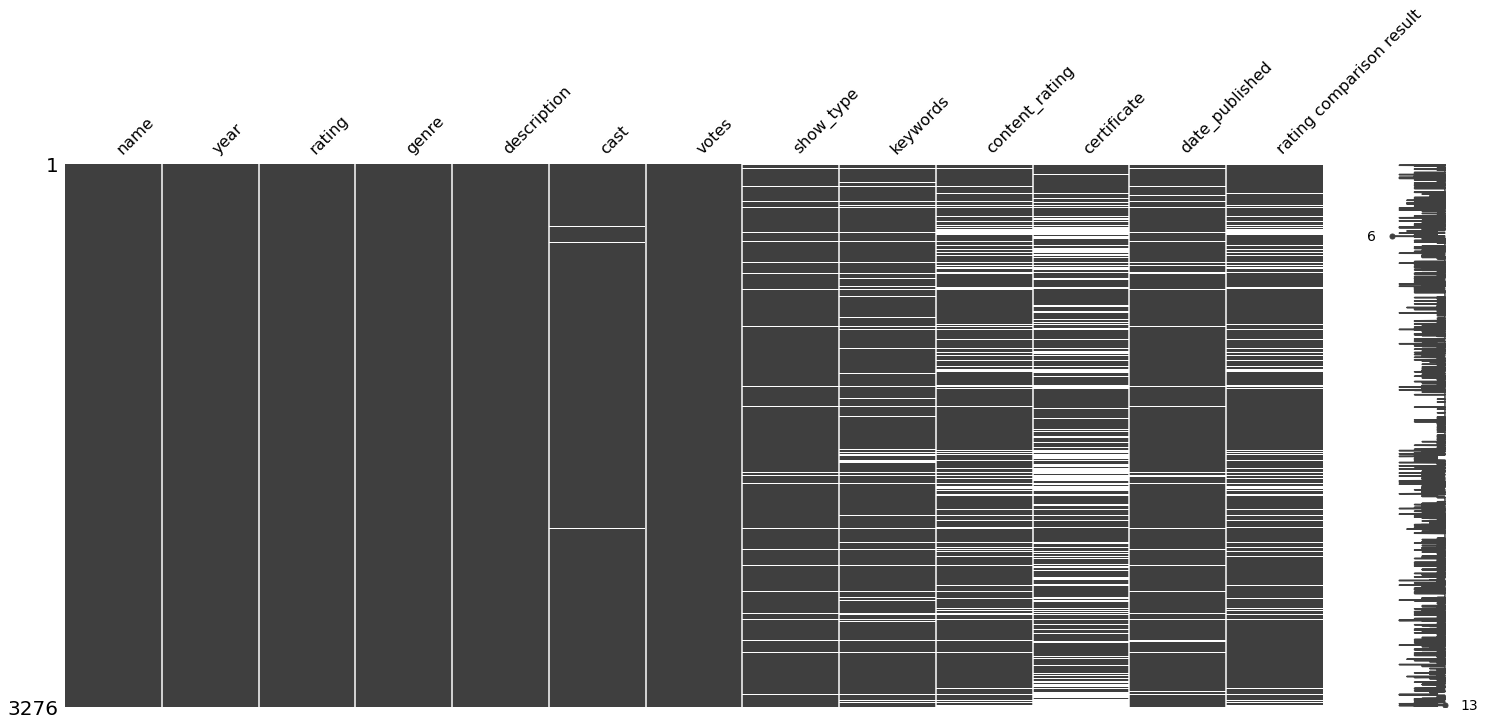

In [3]:
# View percentage of missing data in each column
missing_percentages = df.isnull().mean() * 100
# Print the percentages
print(missing_percentages)
# Assuming your DataFrame is named 'df'
msno.matrix(df)

In [4]:
#Data cleaning
#check and drop dups
duplicates = df.duplicated().sum()
if duplicates > 0:
    df = df.drop_duplicates()

#cerfiticate amd content_rating refer to the same data but scrapped from different elements 
#if the scrapped "certificate" and "content_rating" have different values, use that from "content rating"
df['rating comparison result'] = df.apply(lambda row: row['content_rating'] 
                                          if row['rating comparison result'] == 'Mismatch' 
                                          else row['rating comparison result'], axis=1)

In [5]:
#cleaning the format for the release years ,change attribute names for clarity
df['sequence'] = df['year'].str.extract('(\(I+\))')
df['name'] = df.apply(lambda row: f"{row['name']} {row['sequence']}".strip() if pd.notnull(row['sequence']) else row['name'], axis=1)
df['year_range'] = df['year'].str.extractall('(\d{4})').groupby(level=0).apply(lambda x: x.values.flatten().tolist())
df['year_single'] = df['year'].str.extract('(\d{4})').astype(float)
def combine_years(row):
    if row['year_range'] and len(row['year_range']) > 1:
        return row['year_range']
    else:
        return [int(row['year_single'])] if pd.notnull(row['year_single']) else None
    
df['years'] = df.apply(combine_years, axis=1)
df= df.drop(['year', 'sequence', 'year_range', 'year_single'], axis=1)

#change colomun names: rating -> imdb score, rating comparison result -> rating
df = df.rename(columns={"rating": "imdb score", "rating comparison result": "rating"})
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3275 entries, 0 to 3275
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            3275 non-null   object 
 1   imdb score      3275 non-null   float64
 2   genre           3274 non-null   object 
 3   description     3275 non-null   object 
 4   cast            3243 non-null   object 
 5   votes           3274 non-null   object 
 6   show_type       3099 non-null   object 
 7   keywords        2950 non-null   object 
 8   content_rating  2724 non-null   object 
 9   certificate     2152 non-null   object 
 10  date_published  3083 non-null   object 
 11  rating          2852 non-null   object 
 12  years           3275 non-null   object 
dtypes: float64(1), object(12)
memory usage: 358.2+ KB


In [6]:
#drop columns that won't be used
data_cleaned = df.drop(['content_rating', 'certificate', 'date_published'], axis=1)
data_cleaned.head(50)

#export as a new csv file
data_cleaned.to_csv("data_cleaned.csv", index=False, encoding='utf-8-sig')

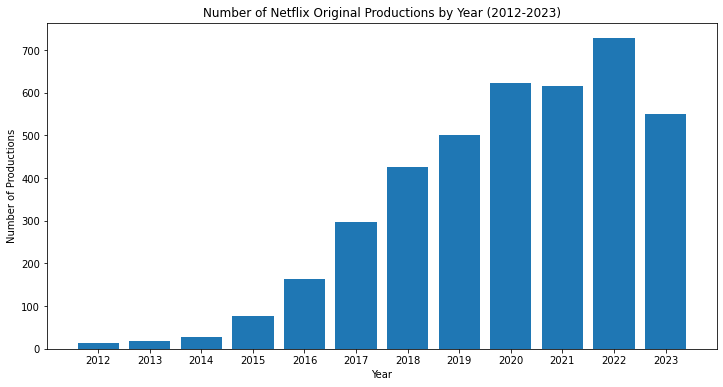

In [7]:
#view the number of netflix original productions by year (2012 onwards)
import matplotlib.pyplot as plt

year_counts = {}
for year_list in data_cleaned['years']:
    # If the show was running for more than one year, count for each year
    if len(year_list) > 1:
        start_year = int(year_list[0])
        end_year = int(year_list[1])
        for year in range(start_year, end_year + 1): 
            if year >= 2012 and year < 2024:  # Considering only years from 2012 onwards
                year_counts[year] = year_counts.get(year, 0) + 1
    else:
        year = int(year_list[0])
        if year >= 2012:  # Single year, count only if it's 2012 or later
            year_counts[year] = year_counts.get(year, 0) + 1

# Sorting the dictionary by year
sorted_year_counts = dict(sorted(year_counts.items()))
# Plotting the adjusted number of productions by year
plt.figure(figsize=(12, 6))
plt.bar(sorted_year_counts.keys(), sorted_year_counts.values())
plt.xlabel('Year')
plt.ylabel('Number of Productions')
plt.title('Number of Netflix Original Productions by Year (2012-2023)')
plt.xticks(list(sorted_year_counts.keys()))
plt.show()

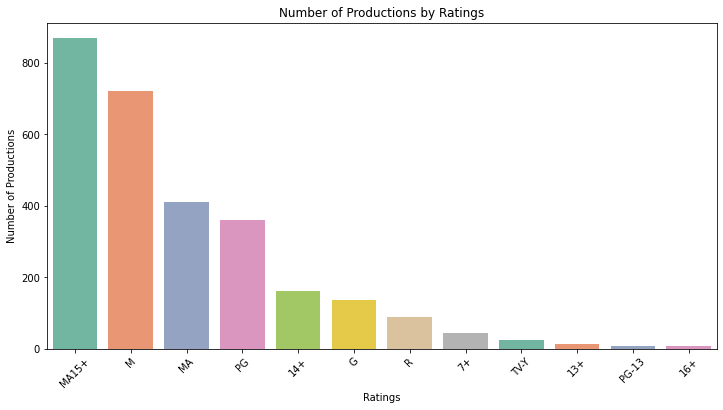

In [8]:
#Creating a mapping for similar labels that refer to the same ratings
rating_mapping = {
    'MA-15': 'MA15+', 'MA15+': 'MA15+', 'M15+': 'MA15+',
    'TV-MA': 'MA', 'MA': 'MA',
    'TV-PG': 'PG', 'PG': 'PG',
    'TV-G': 'G', 'G': 'G',
    'TV-14': '14+', '14+': '14+',
    'R18+': 'R', '18+':'R','R':'R',
    'TV-Y7': '7+', 'TV-Y7-FV': '7+', '7+':'7+'
}

# Apply the mapping to the data
data_cleaned["standardized_rating"] = data_cleaned["rating"].replace(rating_mapping)
temp_data = data_cleaned[~data_cleaned["standardized_rating"].isin(['Unrated', 'Not Rated'])]
# Check the distribution of ratings
standardized_ratings_distribution = temp_data['standardized_rating'].value_counts()
colors = sns.color_palette("Set2", len(standardized_ratings_distribution))

# Plotting the new distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=standardized_ratings_distribution.index, y=standardized_ratings_distribution.values, palette = colors, hue=standardized_ratings_distribution.index,legend=False)
plt.title('Number of Productions by Ratings')
plt.xlabel('Ratings')
plt.ylabel('Number of Productions')
plt.xticks(rotation=45)
plt.show()


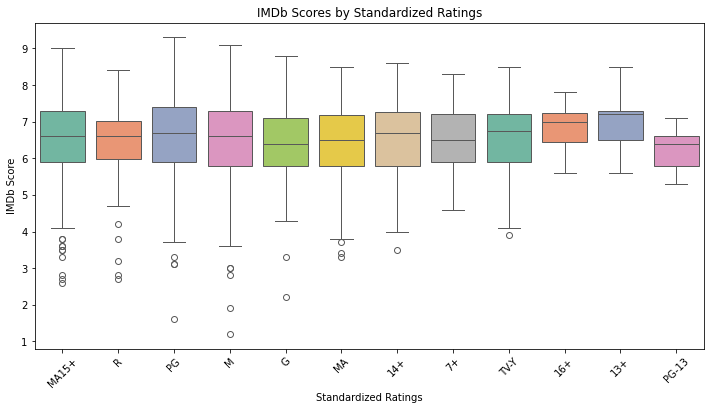

In [9]:
# Plotting IMDb scores by standardized rating
plt.figure(figsize=(12, 6))
sns.boxplot(x='standardized_rating', y='imdb score', data=temp_data, palette=colors, hue='standardized_rating',legend=False)
plt.title('IMDb Scores by Standardized Ratings')
plt.xlabel('Standardized Ratings')
plt.ylabel('IMDb Score')
plt.xticks(rotation=45)
plt.show()

In [10]:
#imdb scores VS genre

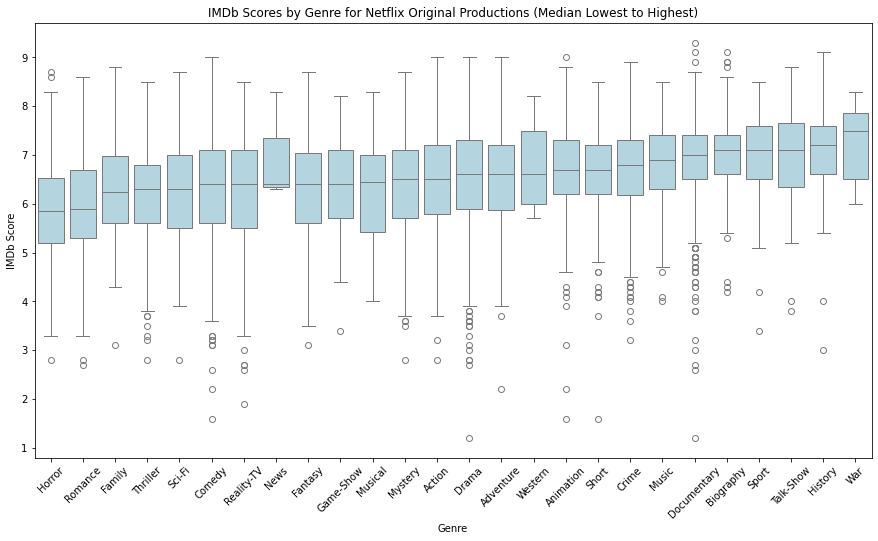

In [11]:
genres_expanded = (data_cleaned.drop('genre', axis=1)
                   .join(data_cleaned['genre'].str.split(',', expand=True)
                   .stack().reset_index(level=1, drop=True).rename('genre'))
                   .reset_index(drop=True))

genres_expanded['genre'] = genres_expanded['genre'].str.strip() 

# Calculating median scores for each genre
median_scores = genres_expanded.groupby('genre')['imdb score'].median().sort_values()

# Sorting the genres based on median scores
sorted_genres = median_scores.index.tolist()

# Plotting IMDb scores by genre, sorted by median scores
plt.figure(figsize=(15, 8))
sns.boxplot(x='genre', y='imdb score', data=genres_expanded, color='lightblue', order=sorted_genres)
plt.xticks(rotation=45)
plt.title('IMDb Scores by Genre for Netflix Original Productions (Median Lowest to Highest)')
plt.ylabel('IMDb Score')
plt.xlabel('Genre')
plt.show()

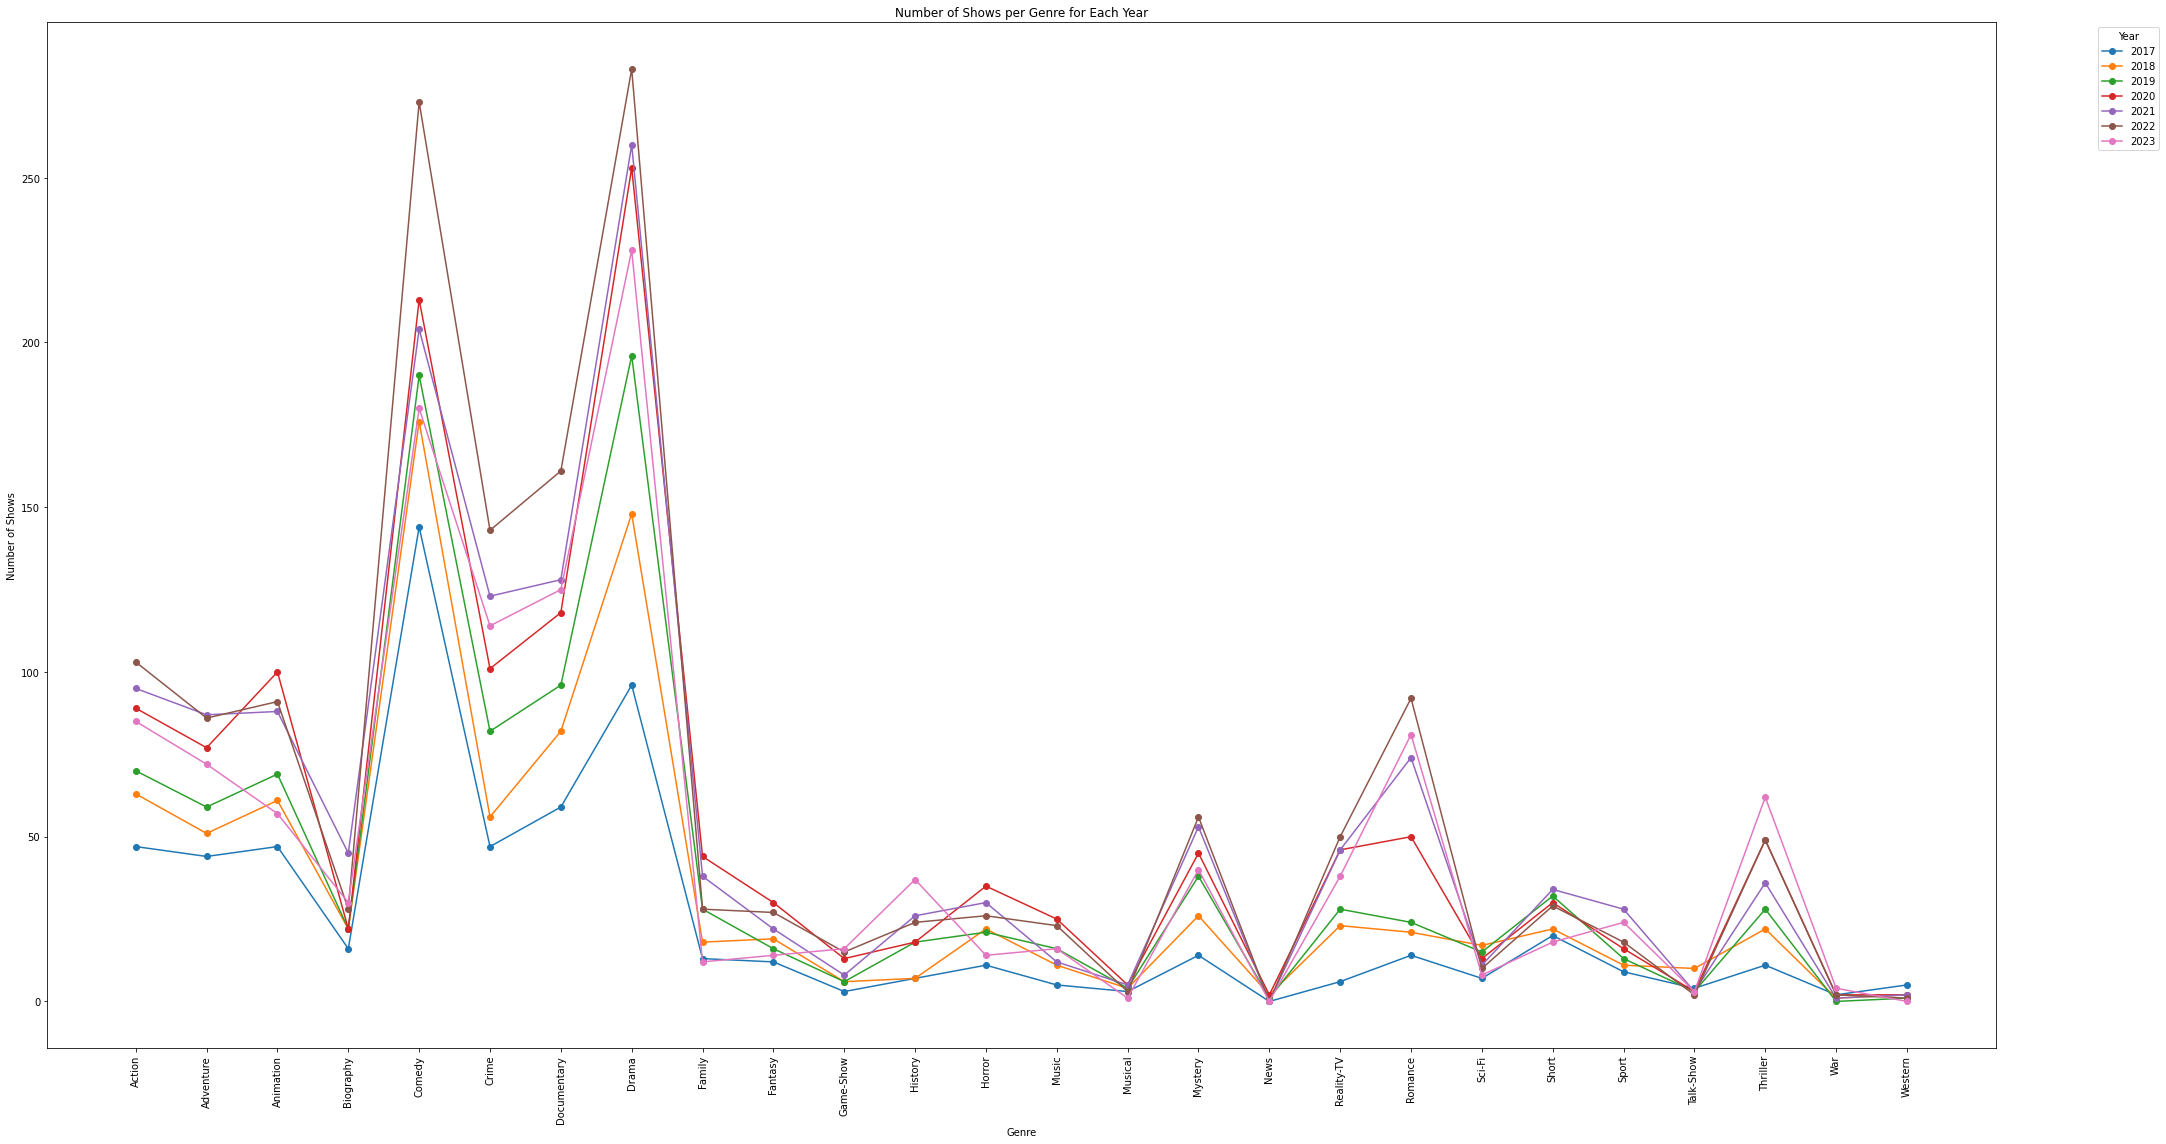

In [12]:
# Function to create a range of years
data_cleaned['genre'] = data_cleaned['genre'].str.split(', ')
genres_expanded = data_cleaned.explode('genre')
def create_year_range(year_list):
    # Ensure all elements in the list are integers
    year_list = [int(year) for year in year_list]

    # Handle the creation of the year range
    if len(year_list) == 1:
        return year_list
    else:
        return list(range(year_list[0], year_list[1] + 1))

# Apply the function to each row and explode the DataFrame to have a row for each year a show was active
genres_expanded['year_range'] = genres_expanded['years'].apply(create_year_range)
genres_expanded = genres_expanded.explode('year_range').rename(columns={'year_range': 'year'})
temp_data2 = genres_expanded[genres_expanded["year"].isin(range(2017, 2024))]
temp_data3 = genres_expanded[genres_expanded["year"].isin(range(2019, 2024))]


# Group by year and genre, and count the number of shows
shows_per_year_genre = temp_data2.groupby(['year', 'genre']).size().reset_index(name='show_count')

# Now we'll pivot the data to have years as columns and genres as rows
pivot_data = shows_per_year_genre.pivot(index='genre', columns='year', values='show_count').fillna(0)

# Plot a line for each year
plt.figure(figsize=(30, 16))
for year in pivot_data.columns:
    plt.plot(pivot_data.index ,pivot_data[year], marker='o', label=year)

plt.title('Number of Shows per Genre for Each Year')
plt.xticks(rotation=90)  # Rotating the x-ticks to prevent overlap
plt.ylabel('Number of Shows')
plt.xlabel('Genre')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


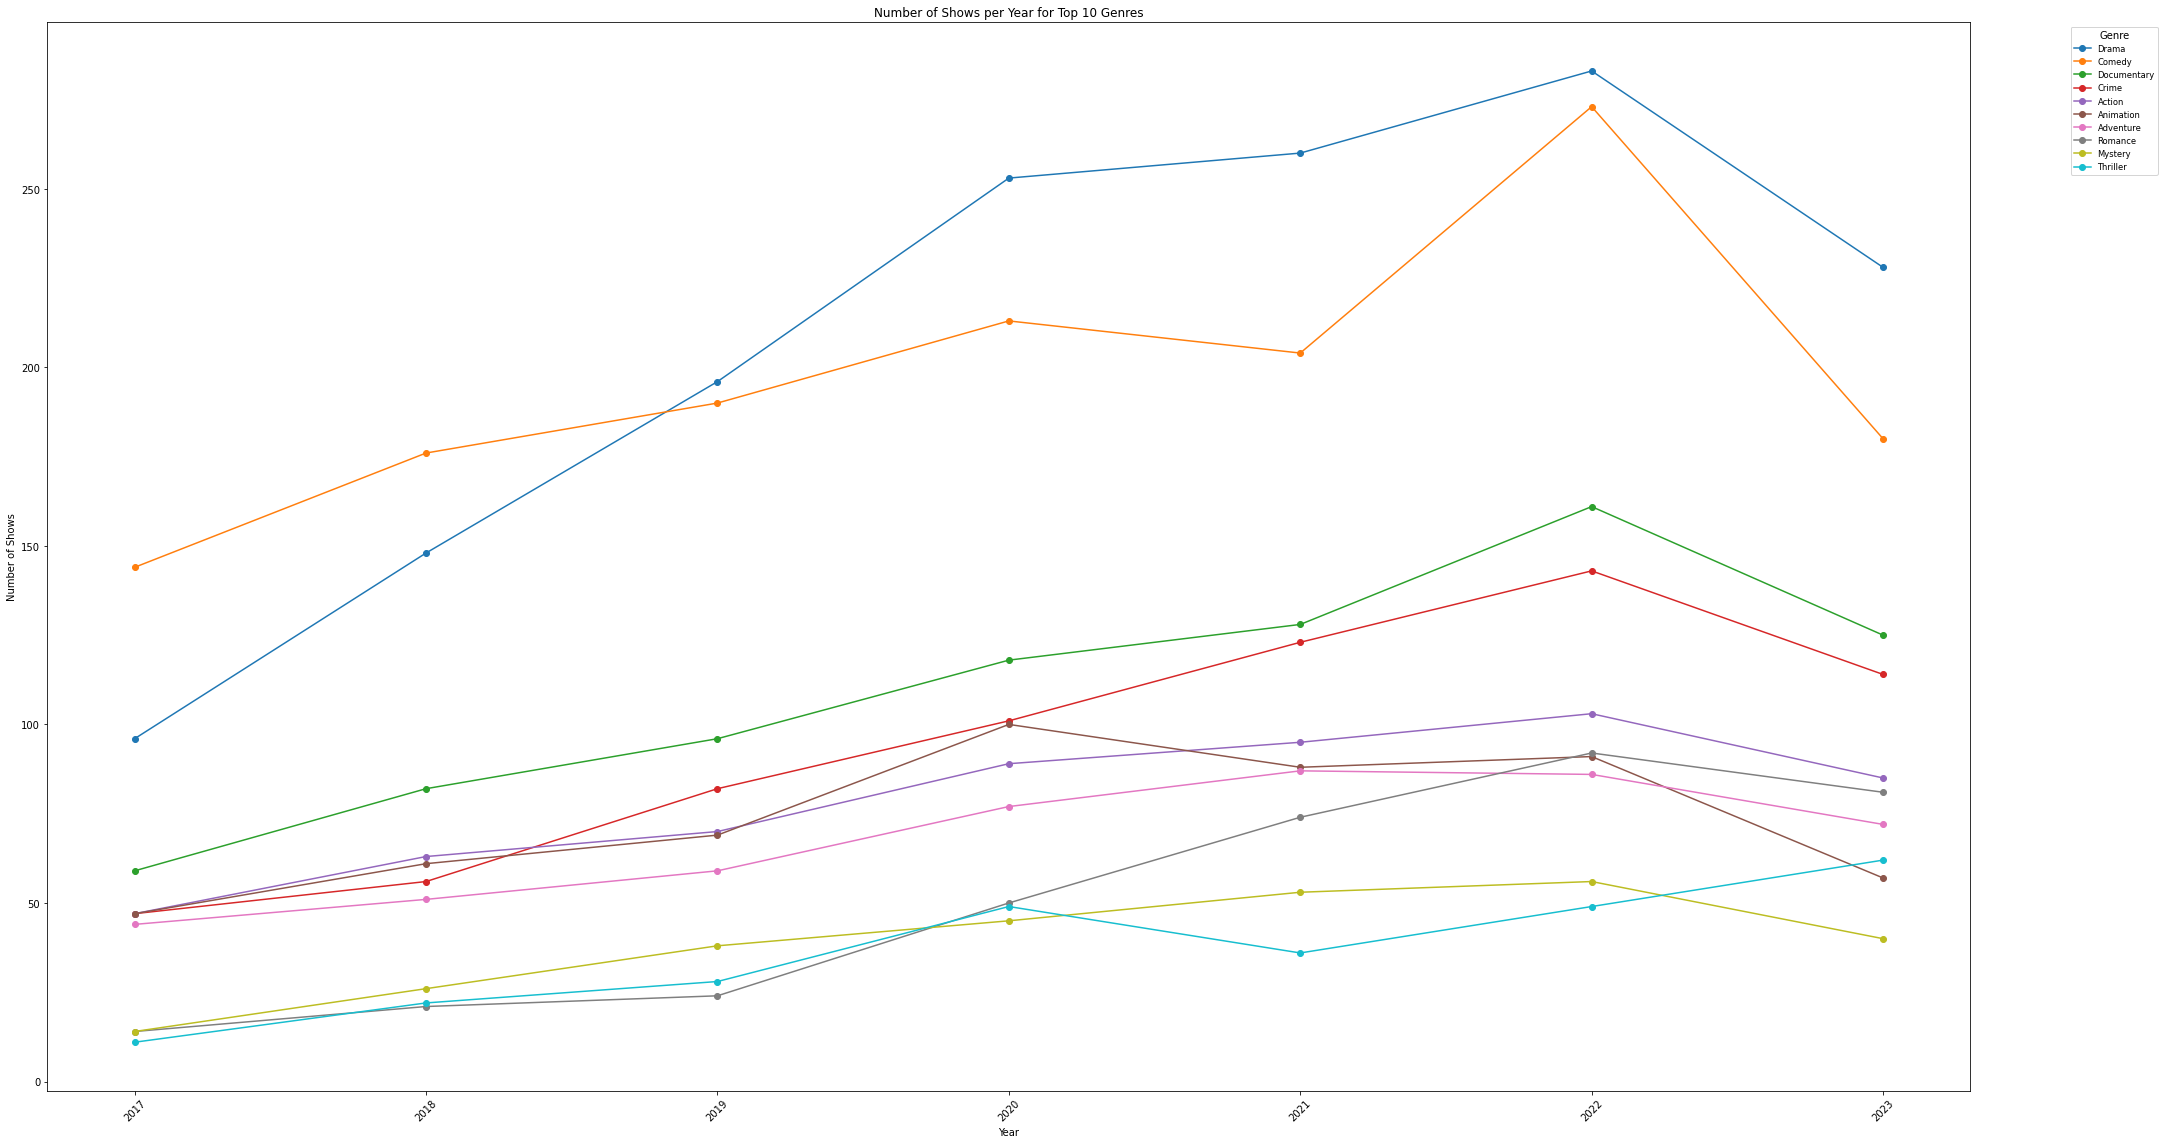

In [13]:
# Pivot the data to have genres as columns and years as rows
pivot_data_genre_lines = shows_per_year_genre.pivot(index='year', columns='genre', values='show_count').fillna(0)

# Determine the top 10 genres based on total number of shows
total_shows_per_genre = pivot_data_genre_lines.sum(axis=0).sort_values(ascending=False)
top_10_genres = total_shows_per_genre.head(10).index.tolist()

# Filter the pivot data to include only the top 10 genres
pivot_data_top_10 = pivot_data_genre_lines[top_10_genres]

# Plotting
plt.figure(figsize=(30, 16))

for i, genre in enumerate(top_10_genres):
    plt.plot(pivot_data_top_10.index, pivot_data_top_10[genre], marker='o', label=genre)

plt.title('Number of Shows per Year for Top 10 Genres')
plt.xticks(rotation=45)
plt.ylabel('Number of Shows')
plt.xlabel('Year')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()

# Save the figure to files
plt.savefig('top_10_genres_number_of_shows_per_year.png', dpi=300) 
plt.savefig('top_10_genres_number_of_shows_per_year.pdf')  



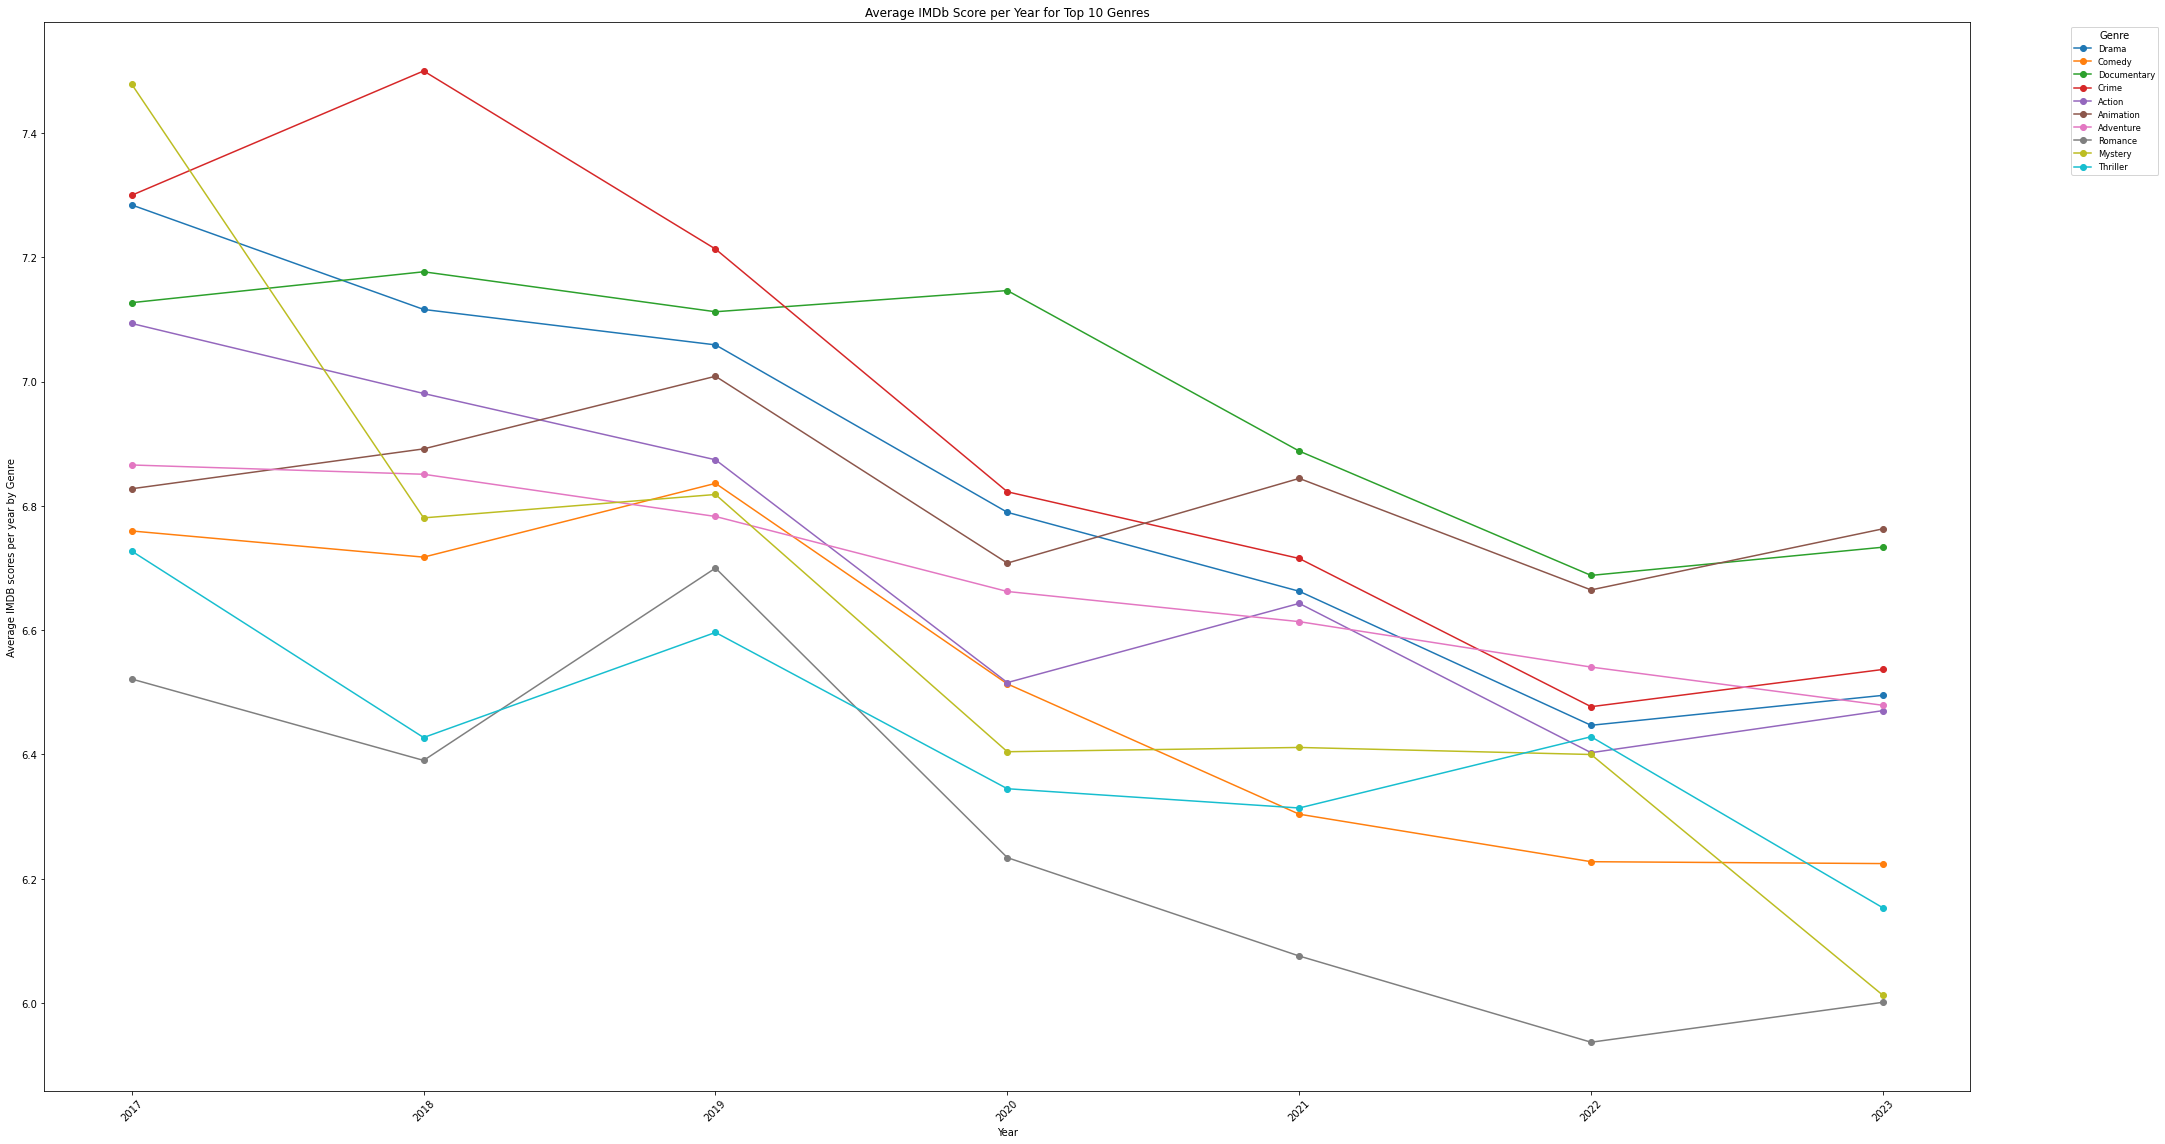

In [14]:
# Calculate the mean of IMDb score for each genre in each year
scores_per_year_genre = temp_data2.groupby(['year', 'genre'])['imdb score'].mean().reset_index(name='average_score')

# Pivot the data to have genres as columns and years as rows
pivot_data_genre_lines_scores = scores_per_year_genre.pivot(index='year', columns='genre', values='average_score').fillna(0)

# Filter the pivot data to include only the top 10 genres
pivot_data_scores_top_10 = pivot_data_genre_lines_scores[top_10_genres]

# Plotting
plt.figure(figsize=(30, 16))

for i, genre in enumerate(top_10_genres):
    plt.plot(pivot_data_scores_top_10.index, pivot_data_scores_top_10[genre], marker='o', label=genre)

plt.title('Average IMDb Score per Year for Top 10 Genres')
plt.xticks(rotation=45)
plt.ylabel('Average IMDB scores per year by Genre')
plt.xlabel('Year')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()

# Save the figure to files
plt.savefig('top_10_genres_average_imdb_score_per_year.png', dpi=300) 
plt.savefig('top_10_genres_average_imdb_score_per_year.pdf')  



In [15]:
#enumerate the production release years in dataset
data_cleaned['years'] = data_cleaned['years'].apply(create_year_range)
data_cleaned.head()

,name,imdb score,genre,description,cast,votes,show_type,keywords,rating,years,standardized_rating
0,House of Cards,8.6,[Drama],A Congressman works with his equally conniving...,"Kevin Spacey, Michel Gill, Robin Wright, Kate ...","526,548",NaN,NaN,MA15+,"[2013, 2014, 2015, 2016, 2017, 2018]",MA15+
1,Hemlock Grove,7.0,"[Drama, Fantasy, Horror]",Secrets are just part of daily life in the sma...,"Famke Janssen, Bill Skarsgård, Landon Liboiron...","42,313",TVSeries,"small town,werewolf,mansion,father daughter re...",R18+,"[2013, 2014, 2015]",R
2,Orange Is the New Black,8.0,"[Comedy, Crime, Drama]",Convicted of a decade old crime of transportin...,"Taylor Schilling, Danielle Brooks, Taryn Manni...","317,559",NaN,NaN,MA15+,"[2013, 2014, 2015, 2016, 2017, 2018, 2019]",MA15+
3,Marco Polo,8.0,"[Action, Adventure, Drama]","In a world replete with greed, betrayal, sexua...","Lorenzo Richelmy, Benedict Wong, Joan Chen, Re...","77,514",TVSeries,"lesbian sex,lesbian interest,mongolia,kung fu ...",MA15+,"[2014, 2015, 2016]",MA15+
4,Bloodline,7.9,"[Drama, Thriller]",A family is forced to face their past secrets ...,"Kyle Chandler, Ben Mendelsohn, Linda Cardellin...","57,758",TVSeries,"florida,large family,sheriff election,wealth,s...",MA15+,"[2015, 2016, 2017]",MA15+


In [47]:
most_popular_productions = pd.DataFrame()
# Top 10 Productions(By Votes) in 2012 - 2023
for year in range(2012, 2024):
    # Filter the DataFrame for the given year
    # The lambda function checks if the 'year' is in the list of years for each row
    yearly_data = data_cleaned[data_cleaned['years'].apply(lambda x: year in x)]
    
    # Sort by 'votes' to get the most popular productions
    yearly_sorted = yearly_data.sort_values(by='votes', ascending=False).head(10)
    
    # Add a 'year' column to identify the year of the data
    yearly_sorted['year'] = year
    
    # Append to the most_popular_productions DataFrame
    most_popular_productions = pd.concat([most_popular_productions, yearly_sorted])

# Reset the index of the final DataFrame
most_popular_productions.reset_index(drop=True, inplace=True)

# Select and rename the required columns
most_popular_productions = most_popular_productions[['year','name', 'votes', 'imdb score', 'genre', 'description', 'keywords']]

# Display the table
most_popular_productions


,year,name,votes,imdb score,genre,description,keywords
0,2012,Trailer Park Boys,"49,485",8.5,"[Comedy, Crime]",Three petty felons have a documentary made abo...,"trailer park,mockumentary,poverty,group of fri..."
1,2012,Longmire,"39,384",8.3,"[Action, Crime, Drama]",Walt Longmire is the dedicated and unflappable...,"father daughter relationship,parent grown chil..."
2,2012,Top Boy,"38,356",8.4,"[Crime, Drama, Thriller]",Two London drug dealers ply their lucrative tr...,"gang,london england,gangster crime,criminal,fr..."
3,2012,Takki,339,6.6,[Drama],Takki is a coming of age story about a young m...,tv mini series
4,2012,Arrested Development,"321,282",8.7,[Comedy],Level-headed son Michael Bluth takes over fami...,NaN
...,...,...,...,...,...,...,...
115,2023,King of Collectibles: The Goldin Touch,955,6.5,[Reality-TV],Ken Goldin and his savvy team run the thrillin...,business and occupation reality tv
116,2023,Mae Martin: SAP,955,6.2,[Comedy],The non-binary comedian Mae Martin speaks of a...,"stand up comedy special,tv special"
117,2023,Vjeran Tomic: The Spider-Man of Paris,952,6.6,"[Documentary, Crime]","In his own words, the burglar behind the 2010 ...",NaN
118,2023,A Vampire in the Family,950,4.7,[Comedy],"Fernandinho is a family man, former football p...",NaN


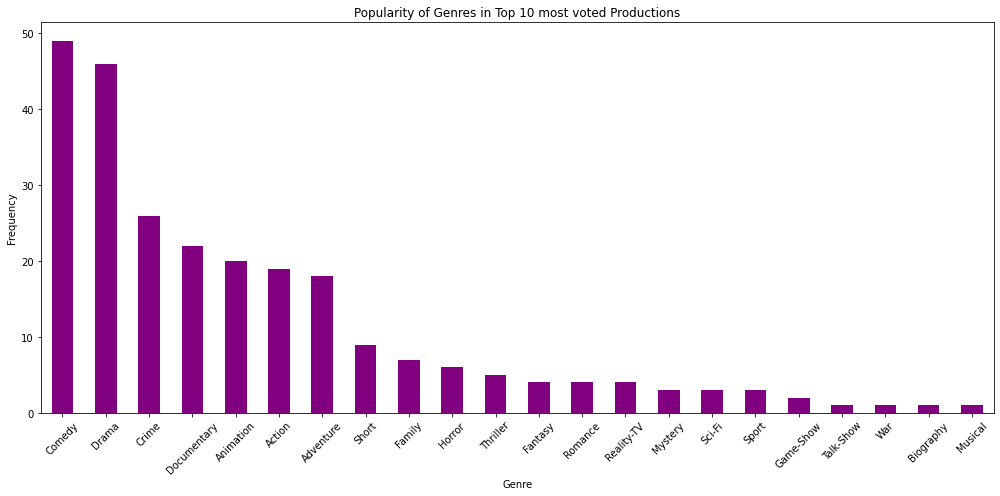

In [48]:
from itertools import chain

# Flatten the list of genres and count the occurrences of each genre
genre_counts = pd.Series(list(chain.from_iterable(most_popular_productions['genre']))).value_counts()

# Plot the results
plt.figure(figsize=(14, 7))
genre_counts.plot(kind='bar', color='purple')
plt.title('Popularity of Genres in Top 10 most voted Productions')
plt.ylabel('Frequency')
plt.xlabel('Genre')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


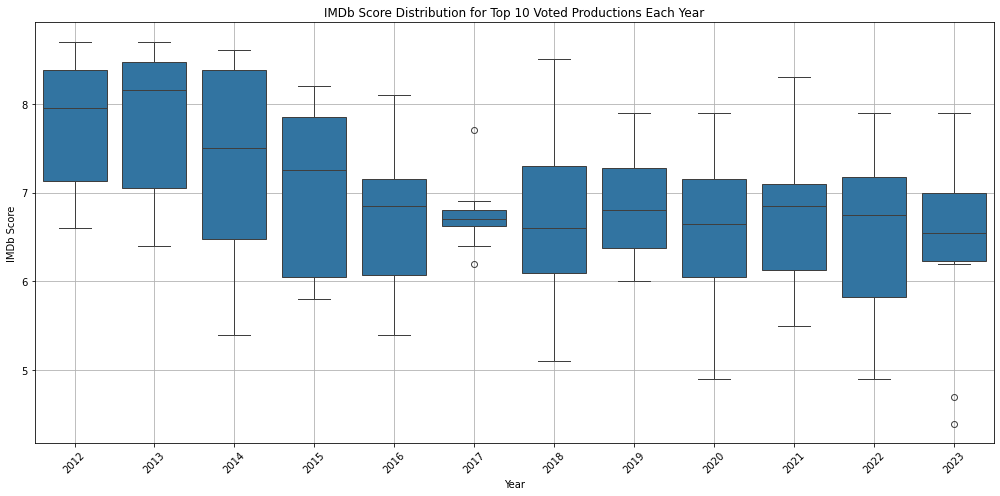

In [49]:
# Make sure 'imdb score' is a numeric type for plotting
most_popular_productions['imdb score'] = pd.to_numeric(most_popular_productions['imdb score'], errors='coerce')

# Plot the results using a boxplot
plt.figure(figsize=(14, 7))
sns.boxplot(data=most_popular_productions, x='year', y='imdb score')
plt.title('IMDb Score Distribution for Top 10 Voted Productions Each Year')
plt.ylabel('IMDb Score')
plt.xlabel('Year')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


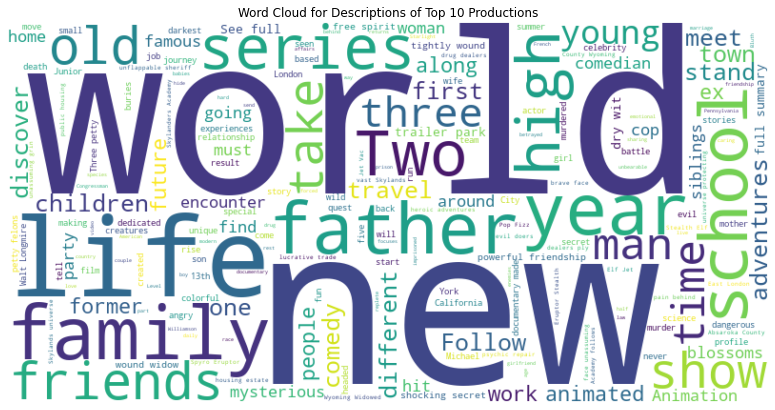

In [50]:
from wordcloud import WordCloud
import re

# Join all descriptions into one text
text = ' '.join(description for description in most_popular_productions['description'])

# Generate and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Descriptions of Top 10 Productions')
plt.axis('off')
plt.show()

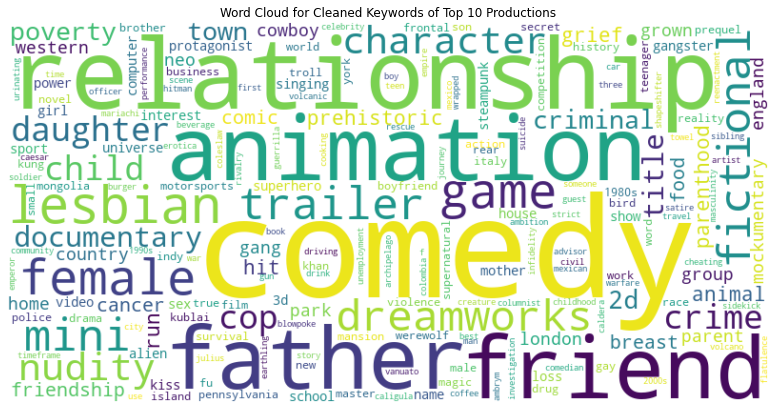

In [51]:
# Function to clean up each keyword
def clean_keyword(keyword):
    # Convert to lowercase
    keyword = keyword.lower()
    # Replace special characters with spaces
    keyword = re.sub(r'[^A-Za-z0-9 ]+', ' ', keyword)
    # Replace multiple spaces with a single space
    keyword = re.sub(r'\s+', ' ', keyword)
    # Strip leading and trailing spaces
    keyword = keyword.strip()
    return keyword

# Apply the cleaning function to each keyword
all_keywords = ', '.join(most_popular_productions['keywords'].dropna().map(clean_keyword))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords,collocations=False).generate(all_keywords)

# Display the word cloud using Matplotlib
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Cleaned Keywords of Top 10 Productions')
plt.axis('off')
plt.show()

In [37]:
highest_score_productions = pd.DataFrame()
# Top 10 Productions(By Votes) in 2012 - 2023
for year in range(2012, 2024):
    # Filter the DataFrame for the given year
    # The lambda function checks if the 'year' is in the list of years for each row
    yearly_data = data_cleaned[data_cleaned['years'].apply(lambda x: year in x)]
    
    # Sort by 'votes' to get the most popular productions
    yearly_sorted = yearly_data.sort_values(by='imdb score', ascending=False).head(10)
    
    # Add a 'year' column to identify the year of the data
    yearly_sorted['year'] = year
    
    # Append to the most_popular_productions DataFrame
    highest_score_productions = pd.concat([highest_score_productions, yearly_sorted])

# Reset the index of the final DataFrame
highest_score_productions.reset_index(drop=True, inplace=True)

# Select and rename the required columns
highest_score_productions = highest_score_productions[['year','name', 'votes', 'imdb score', 'genre', 'description', 'keywords']]

# Display the table
highest_score_productions

,year,name,votes,imdb score,genre,description,keywords
0,2012,Arrested Development,"321,282",8.7,[Comedy],Level-headed son Michael Bluth takes over fami...,NaN
1,2012,Trailer Park Boys,"49,485",8.5,"[Comedy, Crime]",Three petty felons have a documentary made abo...,"trailer park,mockumentary,poverty,group of fri..."
2,2012,Star Wars: The Clone Wars,"117,379",8.4,"[Animation, Action, Adventure]",Jedi Knights lead the Grand Army of the Republ...,NaN
3,2012,Top Boy,"38,356",8.4,"[Crime, Drama, Thriller]",Two London drug dealers ply their lucrative tr...,"gang,london england,gangster crime,criminal,fr..."
4,2012,The Killing,"121,232",8.3,"[Crime, Drama, Mystery]","A police investigation, the saga of a grieving...",NaN
...,...,...,...,...,...,...,...
115,2023,Cobra Kai,"201,582",8.5,"[Action, Comedy, Drama]",Decades after their 1984 All Valley Karate Tou...,"web series,30 years later,sensei,tv sequel to ..."
116,2023,Dew Drop Diaries,57,8.5,"[Animation, Adventure, Comedy]","From finding lost items to cleaning up messes,...",NaN
117,2023,The Railway Men: The Untold Story of Bhopal 1984,"18,532",8.5,"[Drama, History, Thriller]",After a deadly gas leaks from a factory in Bho...,"chemical accident,based on true story,tv mini ..."
118,2023,Top Boy,"38,356",8.4,"[Crime, Drama, Thriller]",Two London drug dealers ply their lucrative tr...,"gang,london england,gangster crime,criminal,fr..."


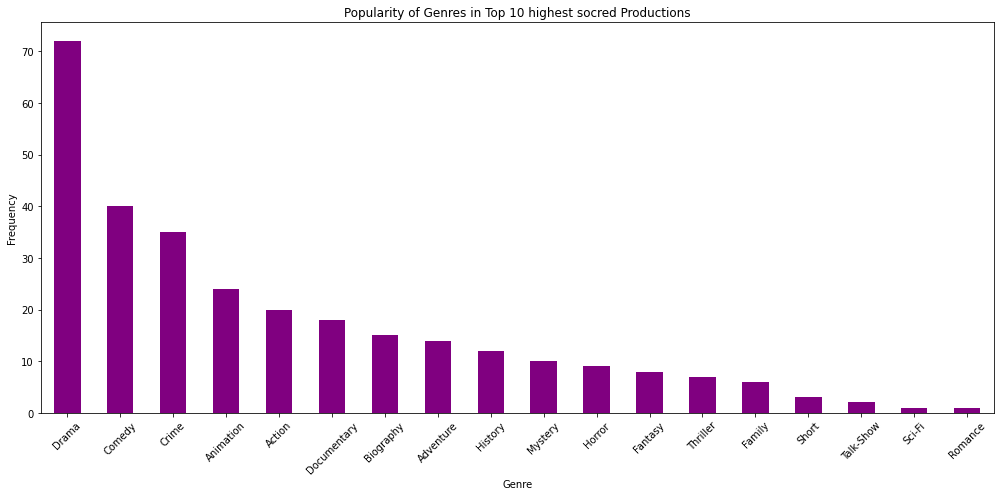

In [38]:
from itertools import chain

# Flatten the list of genres and count the occurrences of each genre
genre_counts = pd.Series(list(chain.from_iterable(highest_score_productions['genre']))).value_counts()

# Plot the results
plt.figure(figsize=(14, 7))
genre_counts.plot(kind='bar', color='purple')
plt.title('Popularity of Genres in Top 10 highest socred Productions')
plt.ylabel('Frequency')
plt.xlabel('Genre')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

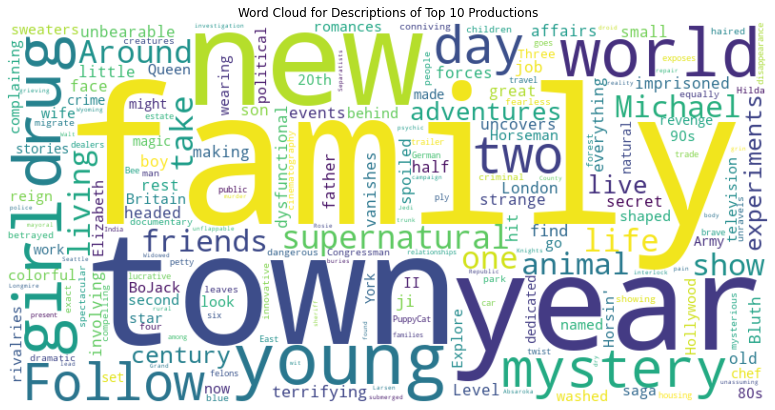

In [43]:
from wordcloud import WordCloud

# Join all descriptions into one text
text = ' '.join(description for description in highest_score_productions['description'])

# Generate and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white',collocations = False).generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Descriptions of Top 10 Productions')
plt.axis('off')
plt.show()
most_popular_productions = pd.DataFrame()

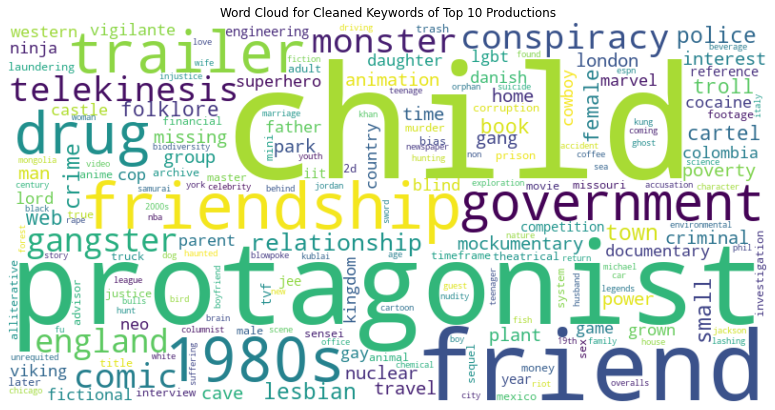

In [42]:
# Function to clean up each keyword
def clean_keyword(keyword):
    # Convert to lowercase
    keyword = keyword.lower()
    # Replace special characters with spaces
    keyword = re.sub(r'[^A-Za-z0-9 ]+', ' ', keyword)
    # Replace multiple spaces with a single space
    keyword = re.sub(r'\s+', ' ', keyword)
    # Strip leading and trailing spaces
    keyword = keyword.strip()
    return keyword

# Apply the cleaning function to each keyword
all_keywords = ', '.join(highest_score_productions['keywords'].dropna().map(clean_keyword))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords,collocations=False).generate(all_keywords)

# Display the word cloud using Matplotlib
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Cleaned Keywords of Top 10 Productions')
plt.axis('off')
plt.show()
